# Create Daily Dataset

this notebook creates a daily dataset, using the dataset with hourly data but using new hourly evaporation data from meteo suisse 

In [2]:
import pandas as pd

df = pd.read_csv("../../Data/clean_data/data_hourly_reduced_variables.csv")

eva =pd.read_csv("../../Data/raw_data/all_data_raw/evaporation_raw_data.txt", sep=";")


In [3]:
eva

,stn,time,ets150d0,erefaod0
0,WAE,20120101,0.03,0.3
1,WAE,20120102,0.04,0.7
2,WAE,20120103,0.25,0.2
3,WAE,20120104,0.11,0.7
4,WAE,20120105,0.06,1.3
...,...,...,...,...
11925,SMA,20221115,0.13,0.4
11926,SMA,20221116,0.44,0.6
11927,SMA,20221117,0.34,1.2
11928,SMA,20221118,0.10,0.6


# convert data_reduced_variables to daily format

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69361 entries, 0 to 69360
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   datetime                 69361 non-null  object 
 1   water_temperature        69361 non-null  float64
 2   barometric_pressure_qfe  69361 non-null  float64
 3   dew_point                69361 non-null  float64
 4   water_level              69361 non-null  float64
 5   precipitation (mm)       69361 non-null  float64
 6   change_rate              69361 non-null  float64
 7   suction_tension (20cm)   69361 non-null  float64
 8   suction_tension (40cm)   69361 non-null  float64
 9   suction_tension (70cm)   69361 non-null  float64
 10  inflow_linth (m3/s)      69361 non-null  float64
 11  outflow_limmat (m3/s)    69361 non-null  float64
 12  evaporation              69361 non-null  float64
dtypes: float64(12), object(1)
memory usage: 6.9+ MB


In [5]:
# convert DateTime column into datetime format
df["datetime"] = pd.to_datetime(df['datetime'], utc=True)

# set DateTime as index
df.set_index("datetime", inplace=True)


In [6]:
# resampling dataframe to daily data by subsetting original dataframe into dataframes where we have to sum the hourly data (dfDS) 
# and dataframes where we have to take the mean of hourly data
dfDS = df[["precipitation (mm)"]].resample("D").sum()

dfDM = df[['suction_tension (20cm)', 'suction_tension (40cm)',
       'suction_tension (70cm)', 'water_temperature',
       'barometric_pressure_qfe', 'dew_point',
       'water_level', "inflow_linth (m3/s)", "outflow_limmat (m3/s)"]].resample("D").mean()




In [7]:
dfDM.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2891 entries, 2012-01-01 00:00:00+00:00 to 2019-11-30 00:00:00+00:00
Freq: D
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   suction_tension (20cm)   2891 non-null   float64
 1   suction_tension (40cm)   2891 non-null   float64
 2   suction_tension (70cm)   2891 non-null   float64
 3   water_temperature        2891 non-null   float64
 4   barometric_pressure_qfe  2891 non-null   float64
 5   dew_point                2891 non-null   float64
 6   water_level              2891 non-null   float64
 7   inflow_linth (m3/s)      2891 non-null   float64
 8   outflow_limmat (m3/s)    2891 non-null   float64
dtypes: float64(9)
memory usage: 225.9 KB


In [8]:
# merge the two datasets again 
dfD = pd.merge(dfDM, dfDS, how = 'inner', on=dfDM.index)#right_index = True, left_index = True)
# set datetime as index
dfD.set_index("key_0", inplace=True)
# change index name
dfD.index.names = ['datetime']
# create variable for change rate of water level since we didn´t want to use the one with hourly data and convert it to daily data
dfD["change_rate"] = dfD["water_level"].pct_change()
# convert datetime index in date only because the datetime index of eva and dfD are not exactly the same 
dfD.index = dfD.index.date
# we drop missing rows
dfD.dropna(inplace=True)

dfD.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2890 entries, 2012-01-02 to 2019-11-30
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   suction_tension (20cm)   2890 non-null   float64
 1   suction_tension (40cm)   2890 non-null   float64
 2   suction_tension (70cm)   2890 non-null   float64
 3   water_temperature        2890 non-null   float64
 4   barometric_pressure_qfe  2890 non-null   float64
 5   dew_point                2890 non-null   float64
 6   water_level              2890 non-null   float64
 7   inflow_linth (m3/s)      2890 non-null   float64
 8   outflow_limmat (m3/s)    2890 non-null   float64
 9   precipitation (mm)       2890 non-null   float64
 10  change_rate              2890 non-null   float64
dtypes: float64(11)
memory usage: 270.9+ KB


In [9]:
dfD

,suction_tension (20cm),suction_tension (40cm),suction_tension (70cm),water_temperature,barometric_pressure_qfe,dew_point,water_level,inflow_linth (m3/s),outflow_limmat (m3/s),precipitation (mm),change_rate
2012-01-02,2.039583,1.566667,1.750000,6.046528,969.340278,4.945139,405.913889,36.147875,121.737083,8.0,0.000004
2012-01-03,2.233333,1.737500,1.666667,5.955556,976.234028,0.836111,405.923611,38.953083,120.771542,1.1,0.000024
2012-01-04,1.716667,1.354167,1.593750,5.911806,974.570833,1.220833,405.927083,39.505792,122.752875,9.9,0.000009
2012-01-05,1.381250,1.139583,1.522917,5.722917,960.572917,1.400694,405.925972,41.539500,139.602042,21.7,-0.000003
2012-01-06,1.862500,1.425000,1.533333,5.533333,972.211806,0.190278,405.949028,47.129458,140.766375,1.2,0.000057
...,...,...,...,...,...,...,...,...,...,...,...
2019-11-26,4.847292,3.544375,4.295208,10.215694,960.428194,6.743333,405.950972,41.814917,66.054125,0.0,0.000022
2019-11-27,4.713542,3.531250,3.632500,10.143056,953.510417,6.558333,405.957083,40.830708,73.559458,6.4,0.000015
2019-11-28,4.770000,3.565000,3.580000,10.066667,956.263889,5.475000,405.957500,40.053792,73.514833,4.9,0.000001
2019-11-29,4.770000,3.565000,3.580000,9.925000,964.315278,5.193056,405.976667,40.361125,91.146333,17.4,0.000047


# clean and prepare evaporation dataset

In [10]:
# drop column we don´t need
eva.drop(columns="erefaod0", inplace=True)
# select only observation from one station (Wädenswil)
eva = eva.loc[eva["stn"]=="WAE"]
# drop the column for station names 
eva.drop(columns = "stn", inplace = True)
# rename coumns
eva.rename(columns={"time": "datetime","ets150d0": "Evapotranspiration (mm)"}, inplace = True)

C:\Users\lucal\AppData\Local\Temp\ipykernel_31704\5843637.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eva.drop(columns = "stn", inplace = True)
C:\Users\lucal\AppData\Local\Temp\ipykernel_31704\5843637.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eva.rename(columns={"time": "datetime","ets150d0": "Evapotranspiration (mm)"}, inplace = True)


In [11]:
eva

,datetime,Evapotranspiration (mm)
0,20120101,0.03
1,20120102,0.04
2,20120103,0.25
3,20120104,0.11
4,20120105,0.06
...,...,...
3971,20221115,0.14
3972,20221116,0.33
3973,20221117,0.31
3974,20221118,0.12


In [12]:
# import pytz package for handling timezones
import pytz
# convert DateTime column into datetime format
eva["datetime"] = pd.to_datetime(eva['datetime'], utc=True)
# function that converts datetime column into CET timezone and accounts for Daylight saving
def add_timezone(df):
    timeZone = pytz.timezone("CET")
    df['datetime'] = df['datetime'].dt.tz_convert(timeZone)
    return df

add_timezone(eva)

# set DateTime as index
eva.set_index("datetime", inplace=True)
# convert datetime index in date only because the datetime index of eva and dfD are not exactly the same 
eva.index = eva.index.date

C:\Users\lucal\AppData\Local\Temp\ipykernel_31704\3845026470.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eva["datetime"] = pd.to_datetime(eva['datetime'], utc=True)
C:\Users\lucal\AppData\Local\Temp\ipykernel_31704\3845026470.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['datetime'] = df['datetime'].dt.tz_convert(timeZone)


In [13]:

eva


,Evapotranspiration (mm)
2012-01-01,0.03
2012-01-02,0.04
2012-01-03,0.25
2012-01-04,0.11
2012-01-05,0.06
...,...
2022-11-15,0.14
2022-11-16,0.33
2022-11-17,0.31
2022-11-18,0.12


# Merge Daily Evapotranspiration and the other Dataframe


In [14]:
# merge the dfD dataframe with the evaporation dataframe on the index
merged_df = pd.merge(dfD, eva, how = 'inner', right_index = True, left_index = True)
# convert to float
merged_df["Evapotranspiration (mm)"] = merged_df["Evapotranspiration (mm)"].astype(float)
# convert index to datetime index
merged_df.index = pd.to_datetime(merged_df.index)

merged_df

,suction_tension (20cm),suction_tension (40cm),suction_tension (70cm),water_temperature,barometric_pressure_qfe,dew_point,water_level,inflow_linth (m3/s),outflow_limmat (m3/s),precipitation (mm),change_rate,Evapotranspiration (mm)
2012-01-02,2.039583,1.566667,1.750000,6.046528,969.340278,4.945139,405.913889,36.147875,121.737083,8.0,0.000004,0.04
2012-01-03,2.233333,1.737500,1.666667,5.955556,976.234028,0.836111,405.923611,38.953083,120.771542,1.1,0.000024,0.25
2012-01-04,1.716667,1.354167,1.593750,5.911806,974.570833,1.220833,405.927083,39.505792,122.752875,9.9,0.000009,0.11
2012-01-05,1.381250,1.139583,1.522917,5.722917,960.572917,1.400694,405.925972,41.539500,139.602042,21.7,-0.000003,0.06
2012-01-06,1.862500,1.425000,1.533333,5.533333,972.211806,0.190278,405.949028,47.129458,140.766375,1.2,0.000057,0.05
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-11-26,4.847292,3.544375,4.295208,10.215694,960.428194,6.743333,405.950972,41.814917,66.054125,0.0,0.000022,0.07
2019-11-27,4.713542,3.531250,3.632500,10.143056,953.510417,6.558333,405.957083,40.830708,73.559458,6.4,0.000015,0.17
2019-11-28,4.770000,3.565000,3.580000,10.066667,956.263889,5.475000,405.957500,40.053792,73.514833,4.9,0.000001,0.10
2019-11-29,4.770000,3.565000,3.580000,9.925000,964.315278,5.193056,405.976667,40.361125,91.146333,17.4,0.000047,0.06


In [15]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2890 entries, 2012-01-02 to 2019-11-30
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   suction_tension (20cm)   2890 non-null   float64
 1   suction_tension (40cm)   2890 non-null   float64
 2   suction_tension (70cm)   2890 non-null   float64
 3   water_temperature        2890 non-null   float64
 4   barometric_pressure_qfe  2890 non-null   float64
 5   dew_point                2890 non-null   float64
 6   water_level              2890 non-null   float64
 7   inflow_linth (m3/s)      2890 non-null   float64
 8   outflow_limmat (m3/s)    2890 non-null   float64
 9   precipitation (mm)       2890 non-null   float64
 10  change_rate              2890 non-null   float64
 11  Evapotranspiration (mm)  2890 non-null   float64
dtypes: float64(12)
memory usage: 293.5 KB


<AxesSubplot: >

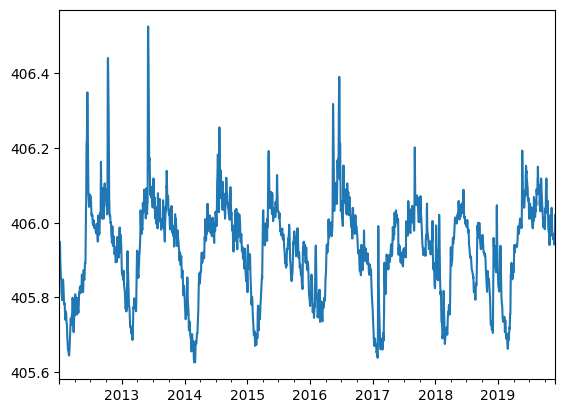

In [16]:
merged_df["water_level"].plot()

In [17]:
# safe dataframe as csv
merged_df.to_csv("../../Data/clean_data/daily_data.csv", index=True)


# Create Weekly Data

In [18]:
# resampling dataframe to weekly data by subsetting original dataframe into dataframes where we have to sum the daily (dfDS) 
# and dataframes where we have to take the mean of hourly data
dfWS = merged_df[["precipitation (mm)", "Evapotranspiration (mm)"]].resample("W").sum()

dfWM = merged_df[['suction_tension (20cm)', 'suction_tension (40cm)',
       'suction_tension (70cm)', 'water_temperature',
       'barometric_pressure_qfe', 'dew_point',
       'water_level', "inflow_linth (m3/s)", "outflow_limmat (m3/s)"]].resample("W").mean()#.interpolate(option="spline")

In [21]:
# merge the two datasets again 
dfW = pd.merge(dfWM, dfWS, on=dfWM.index)
# set datetime as index
dfW.set_index("key_0", inplace=True)
# change index name
dfW.index.names = ['datetime']
# create variable for change rate of water level since we didn´t want to use the one with hourly data and convert it to daily data
dfW["change_rate"] = dfW["water_level"].pct_change()
dfW.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 413 entries, 2012-01-08 to 2019-12-01
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   suction_tension (20cm)   413 non-null    float64
 1   suction_tension (40cm)   413 non-null    float64
 2   suction_tension (70cm)   413 non-null    float64
 3   water_temperature        413 non-null    float64
 4   barometric_pressure_qfe  413 non-null    float64
 5   dew_point                413 non-null    float64
 6   water_level              413 non-null    float64
 7   inflow_linth (m3/s)      413 non-null    float64
 8   outflow_limmat (m3/s)    413 non-null    float64
 9   precipitation (mm)       413 non-null    float64
 10  Evapotranspiration (mm)  413 non-null    float64
 11  change_rate              412 non-null    float64
dtypes: float64(12)
memory usage: 41.9 KB


In [22]:
dfW

,suction_tension (20cm),suction_tension (40cm),suction_tension (70cm),water_temperature,barometric_pressure_qfe,dew_point,water_level,inflow_linth (m3/s),outflow_limmat (m3/s),precipitation (mm),Evapotranspiration (mm),change_rate
datetime,,,,,,,,,,,,
2012-01-08,1.864286,1.509524,1.657143,5.718254,972.342540,1.582381,405.925937,42.463125,130.712589,50.2,0.59,NaN
2012-01-15,3.045833,2.662500,2.254167,5.230734,981.800595,-0.039742,405.856155,41.259768,97.885887,0.0,0.72,-0.000172
2012-01-22,3.732738,2.593155,2.293155,4.960377,975.973750,-0.223948,405.811720,31.684387,85.611571,40.1,0.89,-0.000109
2012-01-29,1.999405,1.724405,1.831548,5.042589,973.659752,1.402569,405.828179,38.195262,101.169554,13.7,0.19,0.000041
2012-02-05,3.800000,2.969048,2.390476,4.035357,975.891310,-9.414226,405.776389,38.501393,81.974750,1.0,0.70,-0.000128
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-11-03,3.469347,2.576207,1.121059,14.486458,964.152153,8.988046,405.981652,49.719399,98.548613,35.8,0.60,0.000031
2019-11-10,2.369476,1.514638,0.815091,13.225020,957.176825,4.898849,406.003480,53.301202,99.244786,20.6,1.35,0.000054
2019-11-17,3.027560,2.366860,1.946473,11.813165,957.502272,1.784901,405.973247,49.496952,92.764923,5.4,1.63,-0.000074


In [23]:
# safe dataframe as csv
dfW.to_csv("../../Data/clean_data/weekly_data.csv", index=True)

# Create Montly Data

In [24]:
# resampling dataframe to monthly data by subsetting original dataframe into dataframes where we have to take the sum and mean (depending on 
# the variable) of the daily data 
dfMS = merged_df[["precipitation (mm)", "Evapotranspiration (mm)"]].resample("M").sum()

dfMM = merged_df[['suction_tension (20cm)', 'suction_tension (40cm)',
       'suction_tension (70cm)', 'water_temperature',
       'barometric_pressure_qfe', 'dew_point',
       'water_level', "inflow_linth (m3/s)", "outflow_limmat (m3/s)"]].resample("M").mean()

In [25]:
# merge the two datasets again 
dfM = pd.merge(dfMM, dfMS, on=dfMM.index)
# set datetime as index
dfM.set_index("key_0", inplace=True)
# change index name
dfM.index.names = ['datetime']
# create variable for change rate of water level since we didn´t want to use the one with hourly data and convert it to daily data
dfM["change_rate"] = dfM["water_level"].pct_change()
dfM.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 95 entries, 2012-01-31 to 2019-11-30
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   suction_tension (20cm)   95 non-null     float64
 1   suction_tension (40cm)   95 non-null     float64
 2   suction_tension (70cm)   95 non-null     float64
 3   water_temperature        95 non-null     float64
 4   barometric_pressure_qfe  95 non-null     float64
 5   dew_point                95 non-null     float64
 6   water_level              95 non-null     float64
 7   inflow_linth (m3/s)      95 non-null     float64
 8   outflow_limmat (m3/s)    95 non-null     float64
 9   precipitation (mm)       95 non-null     float64
 10  Evapotranspiration (mm)  95 non-null     float64
 11  change_rate              94 non-null     float64
dtypes: float64(12)
memory usage: 9.6 KB


In [29]:
dfM.to_csv("../../Data/clean_data/monthly_data.csv", index=True)